# Permutation Feature Importance Notebook 
Author: Seth Billiau 

https://sethbilliau.com/

https://github.com/sethbilliau

In [341]:
import numpy as np 
import pandas as pd 


def generate_data(N, N_dummies):
    '''
    Generate the data set according to the specified equation
    '''
    lst = []
    for i in range(N):
        house = {}
        # Generate color
        if np.random.binomial(1, 0.7) == 1: 
            house['color'] = 'red'
        else: 
            house['color'] = 'blue'
        
        # Generate 3 scores
        house['density'] = np.random.normal(0, 1)
        house['crime'] = np.random.normal(0, 1)
        house['education'] = np.random.normal(0, 1)

        # get price
        house['price'] = (50000 * (house['color'] == 'red') + 20000 * (house['color'] == 'blue') +
                          7000 * house['density'] - 
                          3000 * np.sin(house['crime']) +
                          15000 * house['education']**2)

        lst.append(house)
    df = pd.DataFrame(lst)

    # Generate Dummy Predictors independent of price
    for i in range(N_dummies): 
        df['dummyPred' + str(i + 1)] = np.random.normal(0, 1, N)
        
    price = df.pop('price')
    df['price'] = price
    return df

In [342]:
# Initialize Number of data points and dummy variables
N = 10000
N_dummies = 5

df = generate_data(N, N_dummies)
np.round(df.head(), 2)

,color,density,crime,education,dummyPred1,dummyPred2,dummyPred3,dummyPred4,dummyPred5,price
0,blue,2.27,0.16,0.76,0.90,1.81,-0.12,-0.21,1.01,44106.07
1,red,-0.93,-0.53,-0.08,-1.09,0.85,0.07,0.75,-0.27,45126.69
2,blue,0.07,-1.47,-0.82,-0.03,0.66,1.38,1.90,1.77,33435.81
3,red,-0.85,1.09,-1.31,-1.05,-2.01,-0.46,-0.29,0.06,66976.54
4,red,-0.59,-2.42,-1.00,1.14,1.26,1.59,-1.53,-0.53,62889.80


### Train Test Split, Train RF

In [343]:
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor

X = df.drop(columns = 'price')
X['color'] = (X['color'] == 'red')
y = df.price

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33, 
                                                    random_state=42)


# Instantiate a Random Forest Regressor
regr = RandomForestRegressor(max_depth=100, random_state=0)

# Fit a random forest regressor
regr.fit(X_train, y_train)


RandomForestRegressor(max_depth=100, random_state=0)

### Evaluate MSE

In [344]:
from sklearn.metrics import mean_squared_error

rmse_full_mod = mean_squared_error(regr.predict(X_test), y_test, squared = False)
rmse_full_mod

2271.886423156421

# Implement Permutation feature importance


In [366]:
# Initialize a list of results
results = []

# Iterate through each predictor
for predictor in X_test:
    
    # Create a copy of X_test
    X_test_copy = X_test.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[predictor] = X_test[predictor].sample(frac=1).values
    
    # Calculate the new RMSE
    new_rmse = mean_squared_error(regr.predict(X_test_copy), y_test, squared = False)
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor,
                    'score': new_rmse - rmse_full_mod })

# Put the results into a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score', ascending = False)
    

In [367]:
resultsdf

,pred,score
3,education,27746.934948
0,color,17520.959659
1,density,7162.578719
2,crime,956.246532
7,dummyPred4,25.519156
4,dummyPred1,19.155346
8,dummyPred5,16.180472
5,dummyPred2,3.577779
6,dummyPred3,-14.230027


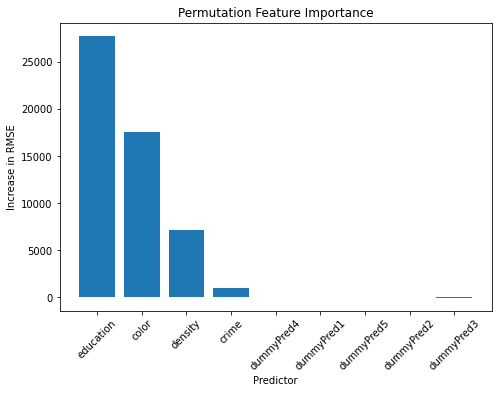

In [369]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Increase in RMSE')
ax.set_xlabel('Predictor')
ax.set_title('Permutation Feature Importance')

predictors = resultsdf.pred
y_pos = range(len(predictors))
scores = resultsdf.score
ax.bar(predictors,scores)
plt.xticks(y_pos, predictors, rotation=45)
plt.show()